- run through different transformers with different configurations
- plot the output so the shapelet generated and the transformed values
- ST take the basic motion data, find the shapelets and then plot back where the shapelet is in the motion
- useful visualisation tools are ShapeletVisualizer, ShapeletTransformVisualizer

# Introduction

This notebook explores the shapelet transformers implemented within aeon. For a wider understanding please refer to antoines notebook first.

# The three transformers

In [14]:
from aeon.registry import all_estimators

for k, v in all_estimators("transformer", filter_tags={"algorithm_type": "shapelet"}):
    print(f"{k}: {v}")

RSAST: <class 'aeon.transformations.collection.shapelet_based._rsast.RSAST'>
RandomDilatedShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._dilated_shapelet_transform.RandomDilatedShapeletTransform'>
RandomShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._shapelet_transform.RandomShapeletTransform'>


# A little bit about each transformer (write in order of release)

## Shapelet transform

# Random Dilated Shapelet Transform

# Scalable and Accurate Subsequence Transform

# The dataset

This human activity recognition dataset is time series data generated by accelerometer and gyroscope sensors (attitude, gravity, user acceleration, and rotation rate) used in the paper {Malekzadeh et al., Mobile Sensor Data Anonymization, in proc the International Conference on Internet of Things Design and Implementation, 2019 (Link Here) A total of 24 participants in a range of gender, age, weight, and height performed 6 activities in 15 trials in the same environment and conditions: downstairs (dws), upstairs , walking, jogging, sitting, and standing.

In [9]:
from aeon.datasets import load_classification

X_train, y_train = load_classification("MotionSenseHAR", split="train")
X_test, y_test = load_classification("MotionSenseHAR", split="test")

print(f"shape of the array: {X_train.shape}")
print(f"n_samples = {X_train.shape[0]}")
print(f"n_channels = {X_train.shape[1]}")
print(f"n_timepoints = {X_train.shape[2]}")

shape of the array: (966, 12, 1000)
n_samples = 966
n_channels = 12
n_timepoints = 1000


# Discuss how we will explore the transform, compare them, and hopefully understand something about the motion data

- track how long it takes to fit the transform
- compare the shapelets
    - compare their discriminative ability

## Fitting each transform to training data

### Random Shapelet Transform

In [11]:
import time
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

# Start the timer
start_time = time.time()

rst = RandomShapeletTransform(max_shapelets=10).fit(X_train, y_train)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

rst.transform(X_test).shape

(265, 6)

### Random Dilated Shapelet Transform

In [17]:
from aeon.transformations.collection.shapelet_based import RandomDilatedShapeletTransform
import time
# Start the timer
start_time = time.time()

rsdt = RandomDilatedShapeletTransform(max_shapelets=10000).fit(X_train, y_train)
# Stop the timer
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

rsdt.transform(X_test).shape

Time taken to fit: 54.3779 seconds


(265, 30)

### Scalable and Accurate Subsequence Transform

In [18]:
# from aeon.transformations.collection.shapelet_based import SAST
# import time
# # Start the timer
# start_time = time.time()

# sast = SAST().fit(X_train, y_train)
# # Stop the timer
# end_time = time.time()

# # Calculate and print the elapsed time
# elapsed_time = end_time - start_time
# print(f"Time taken to fit: {elapsed_time:.4f} seconds")

# sast.transform(X_test).shape

ValueError: Data seen by instance of SAST has multivariate series, but SAST cannot handle multivariate series. 

## Fitting each visualizer

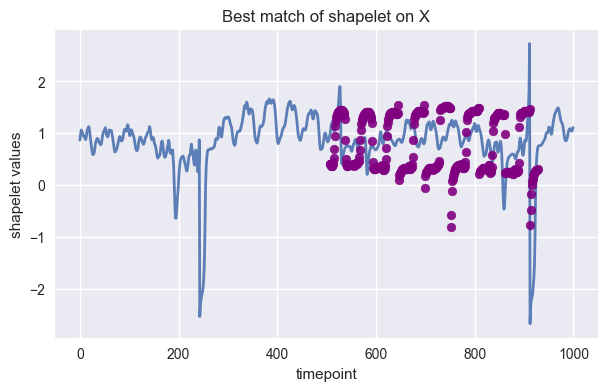

In [12]:
from aeon.visualisation import ShapeletTransformerVisualizer

st_vis = ShapeletTransformerVisualizer(st)
id_shapelet = 0  # Identifier of the shapelet

fig = st_vis.plot_on_X(id_shapelet, X_test[1], figure_options={"figsize": (7, 4)})

Text(0.5, 1.0, 'Distance vector of shapelet 0 on X')

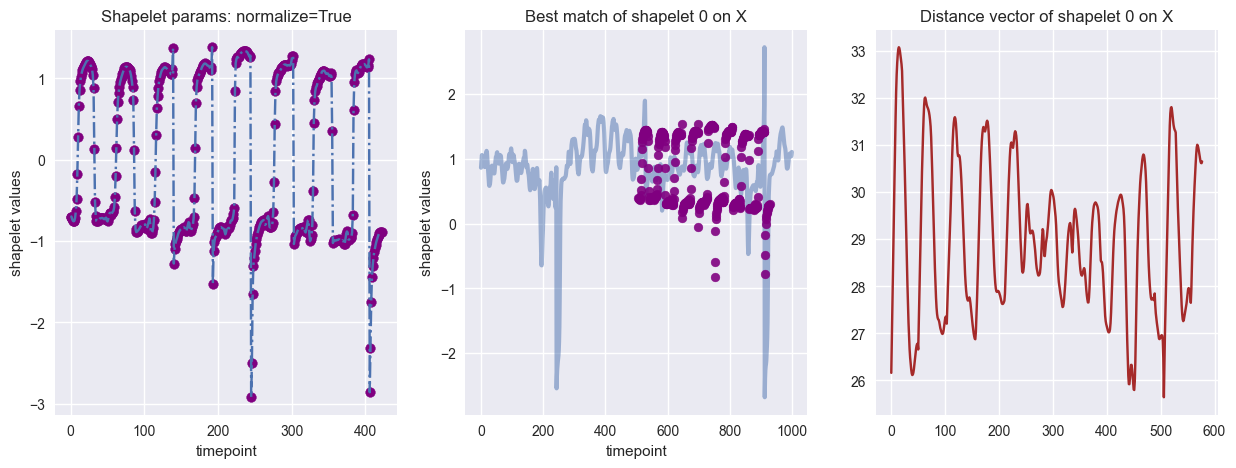

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
st_vis.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
st_vis.plot_on_X(
    id_shapelet, X_test[1], ax=ax[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
st_vis.plot_distance_vector(
    id_shapelet, X_test[1], ax=ax[2], line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

# Interpreting the data